In [ ]:
import librosa
from librosa import feature
from librosa import display as ldisplay
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
import torchaudio
import numpy as np
from IPython.display import Audio, display 


In [ ]:
def visualize_row(row):
  fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(15, 15))
  img1 = ldisplay.specshow(row["mfcc"], ax=ax[0], x_axis='time')
  ax[0].set(title='MFCC')
  ax[0].label_outer()
  img2 = ldisplay.specshow(row["delta"], ax=ax[1], x_axis='time')
  ax[1].set(title=r'MFCC-$\Delta$')
  ax[1].label_outer()
  img3 = ldisplay.specshow(row["delta2"], ax=ax[2], x_axis='time')
  ax[2].set(title=r'MFCC-$\Delta^2$')
  fig.colorbar(img1, ax=[ax[0]])
  fig.colorbar(img2, ax=[ax[1]])
  fig.colorbar(img3, ax=[ax[2]])


In [ ]:
def create_df(file_load, sample_rate, window_length, hop_length, BASEPATH = "/content/speech_commands/"):
  dataset = {}
  f_read = open(file_load, 'r')
  for line in f_read:
    line = line.replace("\n", "")
    label = line.split("/")[0]
    y, sr = librosa.load(BASEPATH + line, sr=sample_rate)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, win_length=window_length, hop_length=hop_length, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfccs, width=7)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2, width=7)
    if not label in dataset:
      dataset[label] = []
    
    dataset[label].append({
        "signal": y,
        "mfcc": mfccs/np.max(np.abs(mfccs),axis=0),
        "delta": mfcc_delta/np.max(np.abs(mfcc_delta),axis=0),
        "delta2": mfcc_delta2/np.max(np.abs(mfcc_delta2),axis=0),
    })

  f_read.close()
  dfs = []
  for k,v in dataset.items():
    tmp = pd.DataFrame(v)
    tmp['label'] = k
    dfs.append(tmp)

  df = pd.concat(dfs)
  return df


In [ ]:
def oversample(df):
    classes = df.label.value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['label'] == key]) 
    classes_sample = []
    for i in range(1,len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[0]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return final_df

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!mkdir ./speech_commands/
!tar -xf /content/speech_commands_v0.02.tar.gz -C ./speech_commands

--2022-10-23 21:44:41--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.98.128, 2607:f8b0:400e:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.98.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G   156MB/s    in 15s     

2022-10-23 21:44:56 (155 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [ ]:
sample_rate = 16000
sample_time = 1000/sample_rate
window_length = int(40 // (1000/sample_rate))
hop_length =  window_length // 2

"Frame duration: {}ms".format(1000/sample_rate), "Window duration: {}ms".format(window_length * 1000/sample_rate)

('Frame duration: 0.0625ms', 'Window duration: 40.0ms')

In [ ]:
y, sr = librosa.load("/content/speech_commands/backward/042a8dde_nohash_0.wav")
mfcc = librosa.feature.mfcc(y=y, sr=sample_rate, win_length=window_length, hop_length=hop_length, n_mfcc=13)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

"Duration: {}ms".format(sample_time*len(y)), mfcc.shape[1]*(window_length-(window_length -hop_length))*sample_time

('Duration: 1378.125ms', 1380.0)

In [ ]:
LOAD_PICKLE = True
if LOAD_PICKLE:
  train_df = pd.read_pickle("/content/train.pkl")
  val_df = pd.read_pickle("/content/val.pkl")
else:
  train_df = create_df("/content/speech_commands/testing_list.txt",sample_rate, window_length, hop_length)
  val_df = create_df("/content/speech_commands/validation_list.txt",sample_rate, window_length, hop_length)
  train_df.to_pickle('train.pkl')
  val_df.to_pickle('val.pkl')

In [ ]:
train_df = oversample(train_df) 

In [ ]:
tmp = val_df.iloc()[2000]
print(tmp.label)
wn = Audio(data=tmp.signal, rate=sample_rate)
display(wn)

go


In [ ]:
max_length = max(
    train_df.mfcc.apply(lambda x: x[0].size).max(),
    train_df.delta.apply(lambda x: x[0].size).max(),
    val_df.mfcc.apply(lambda x: x[0].size).max(),
    val_df.delta.apply(lambda x: x[0].size).max()
)
max_length

51

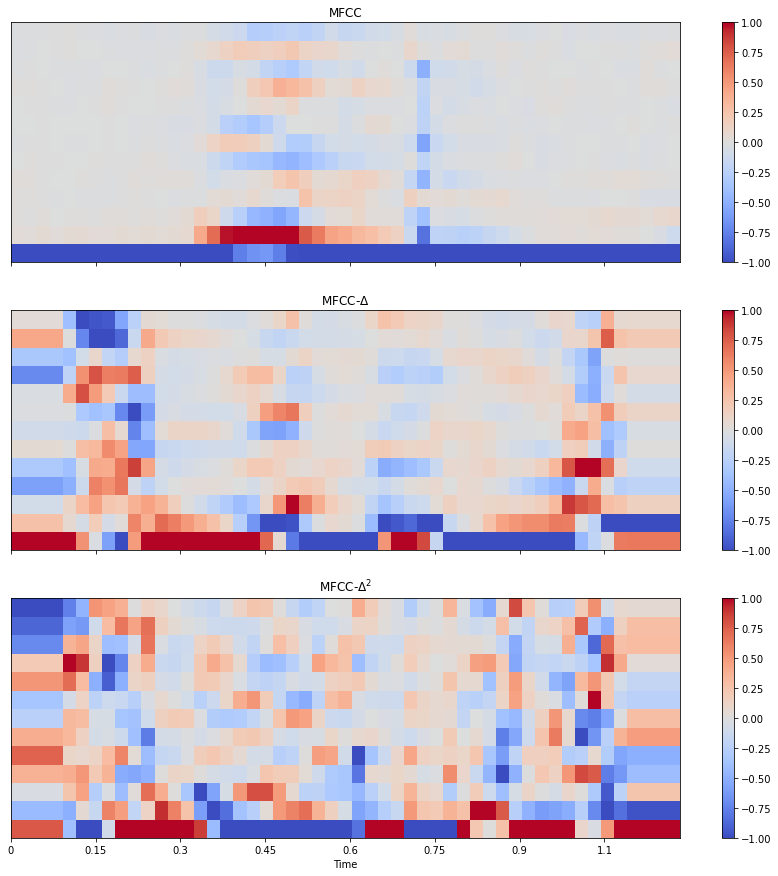

In [ ]:
visualize_row(train_df.iloc()[0])

# Clasificador

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sn
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
def pad_tensor(tensor, max_size=max_length):
  target = torch.zeros(13, max_size)
  _, y_shape = tensor.size()
  cut_value = min(y_shape, max_size)
  half_pad = (max_size - cut_value)//2
  target[:, half_pad:cut_value + half_pad] = tensor
  return target


In [ ]:
c2i={}
i2c={}
categories = sorted(train_df["label"].unique())
for i, category in enumerate(categories):
  c2i[category]=i
  i2c[i]=category


class SCData(Dataset):
  def __init__(self, df, labels, c2i, i2c):
    self.df = df
    self.data = []
    self.labels = []
    self.caegories = labels
    self.c2i = c2i
    self.i2c = i2c
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      
      mfcc = pad_tensor(torch.Tensor(row['mfcc']))
      delta = pad_tensor(torch.Tensor(row['delta']))
      delta2 = pad_tensor(torch.Tensor(row['delta2']))

      # print(mfcc.size(), delta.size(), delta2.size(), torch.cat((mfcc , delta, delta2), 0).size())

      self.data.append(torch.cat((mfcc , delta, delta2), 0))
      # self.data.append(mfcc)
      self.labels.append(self.c2i[row['label']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [ ]:
def plot_train_evo(loss, train_acc, val_acc):
  # Create count of the number of epochs
  epoch_count = range(1, len(loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, loss, 'b-')
  plt.legend(['Training Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show();

  plt.plot(epoch_count, train_acc, 'r--')
  plt.plot(epoch_count, val_acc, 'o--')
  plt.legend(['Train Acc', 'Val acc'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.show();

In [ ]:
def test_model(model, test_loader, sequence_length, input_size):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for audios, labels in test_loader:
        audios = audios.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(audios)

        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy: {acc} %')
    return n_correct / n_samples
  


In [ ]:
def plot_conf_matrix(model):
  yh = []
  ys = []
  for i, (audios, labels) in enumerate(valid_loader):
    y_hat = model(audios.reshape(-1, sequence_length, input_size).to(device))
    y_hat = y_hat.argmax(1)
    y = labels
    yh = yh + y_hat.tolist()
    ys = ys + y.tolist()
    
  df_cm = pd.DataFrame(confusion_matrix(ys, yh), index = categories,
                    columns = categories)
  plt.figure(figsize = (20,18))
  sn.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
def train(model, train_loader, criterion, optimizer, test_loader, validation_loader, sequence_length, input_size):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  losses_evolution = []
  train_acc_evolution = []
  val_acc_evolution = []

  n_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      for i, (audios, labels) in enumerate(train_loader):  

          audios = audios.reshape(-1, sequence_length, input_size).to(device)
          labels = labels.to(device)
          
          outputs = model(audios)
          loss = criterion(outputs, labels)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          if (i+1) % 100 == 0:
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      
      losses_evolution.append(loss.item())
      val_acc_evolution.append(test_model(model, valid_loader, sequence_length, input_size))
      train_acc_evolution.append(test_model(model, test_loader, sequence_length, input_size))
      
  return losses_evolution, train_acc_evolution, val_acc_evolution

In [ ]:
def train_model(model, criterio, optimizer, scheduler, num_epochs = 25, train_loader, test_loader, ):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)
    
    #Train model
    scheduler.step()
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss /len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
      
    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    #Validation 
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
     
    epoch_loss = running_loss /len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)
      
    print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
  print('Best val accucary: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

In [ ]:
num_epochs = 200
batch_size = 32

In [ ]:
train_df, test_df = train_test_split(train_df, test_size=0.15)

In [ ]:
train_data = SCData(train_df, categories, c2i, i2c)
test_data = SCData(test_df, categories, c2i, i2c)
valid_data = SCData(val_df, categories, c2i, i2c)


100%|██████████| 9981/9981 [00:01<00:00, 5069.34it/s]


In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.batchNorm = nn.BatchNorm1d(51, input_size)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=0,  batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        x = self.batchNorm(x)
        out, _ = self.rnn(x, h0)  
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
num_classes = len(categories)

learning_rate = 4e-3


input_size = 39
sequence_length = max_length
hidden_size = 64
num_layers = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

losses_evolution, train_acc_evolution, val_acc_evolution = train(model, train_loader, criterion, optimizer, test_loader, valid_loader, sequence_length=sequence_length, input_size=input_size)


Accuracy: 3.927462178138463 %
Accuracy: 4.23348300192431 %
Accuracy: 4.107804829175433 %
Accuracy: 4.7359418430617914 %
Accuracy: 4.007614467488228 %
Accuracy: 5.494975411588626 %
Accuracy: 3.857328924957419 %
Accuracy: 6.5640367757109255 %
Accuracy: 3.7070433824266105 %
Accuracy: 6.392986957451358 %
Accuracy: 4.3382426610560065 %
Accuracy: 7.205473594184306 %
Accuracy: 3.5467388037270813 %
Accuracy: 7.237545435107975 %
Accuracy: 4.157900010019036 %
Accuracy: 7.130639298695745 %
Accuracy: 4.5887185652740206 %
Accuracy: 7.2803078896728675 %
Accuracy: 4.3382426610560065 %
Accuracy: 8.135556980970708 %
Accuracy: 4.718966035467388 %
Accuracy: 9.140474663245671 %
Accuracy: 4.919346758841799 %
Accuracy: 8.638015822108189 %
Accuracy: 5.8911932672076945 %
Accuracy: 9.300833867864016 %
Accuracy: 5.510469892796313 %
Accuracy: 8.702159503955526 %
Accuracy: 5.871155194870253 %
Accuracy: 9.856745777207612 %
Accuracy: 7.854924356276926 %
Accuracy: 12.240752619200341 %
Accuracy: 8.556256888087367 %
A

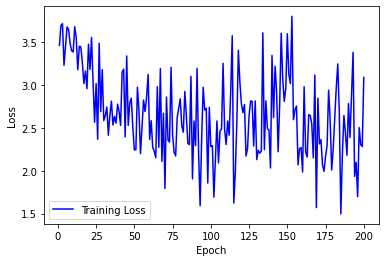

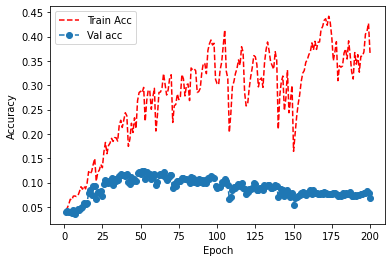

In [ ]:
plot_train_evo(losses_evolution, train_acc_evolution, val_acc_evolution)

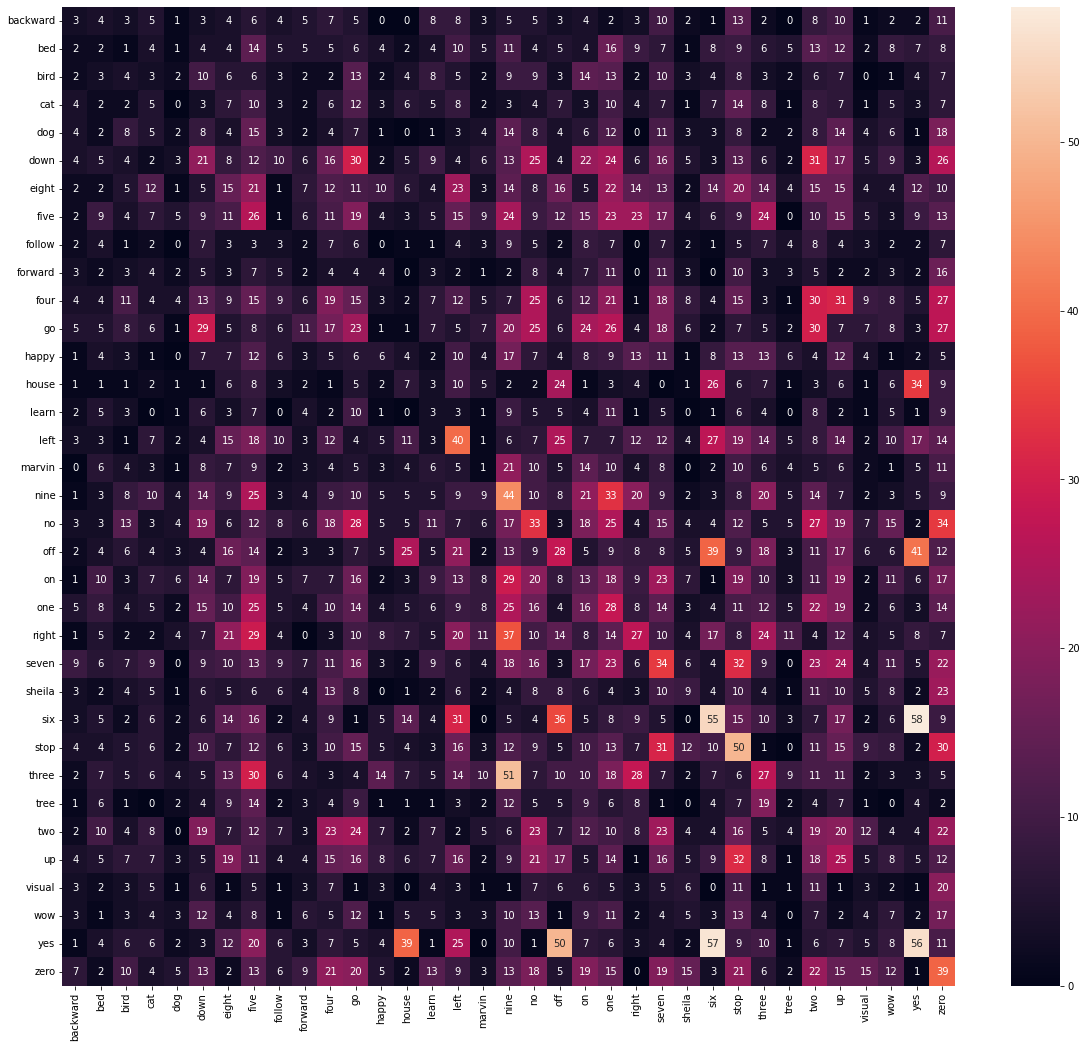

In [ ]:
RNN_model = model
plot_conf_matrix(RNN_model)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        out, _ = self.lstm(x, (h0,c0))  
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(categories)
learning_rate = 4e-5

# input_size = 60
# sequence_length = 32
# hidden_size = 128
# num_layers = 2

model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

losses_evolution, train_acc_evolution, val_acc_evolution = train(model, train_loader, criterion, optimizer, test_loader, valid_loader, sequence_length=sequence_length, input_size=input_size)

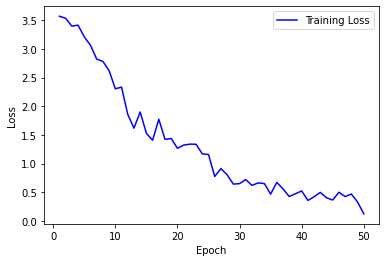

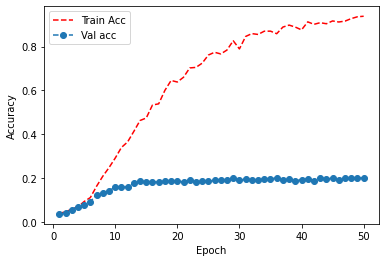

In [ ]:
plot_train_evo(losses_evolution, train_acc_evolution, val_acc_evolution)

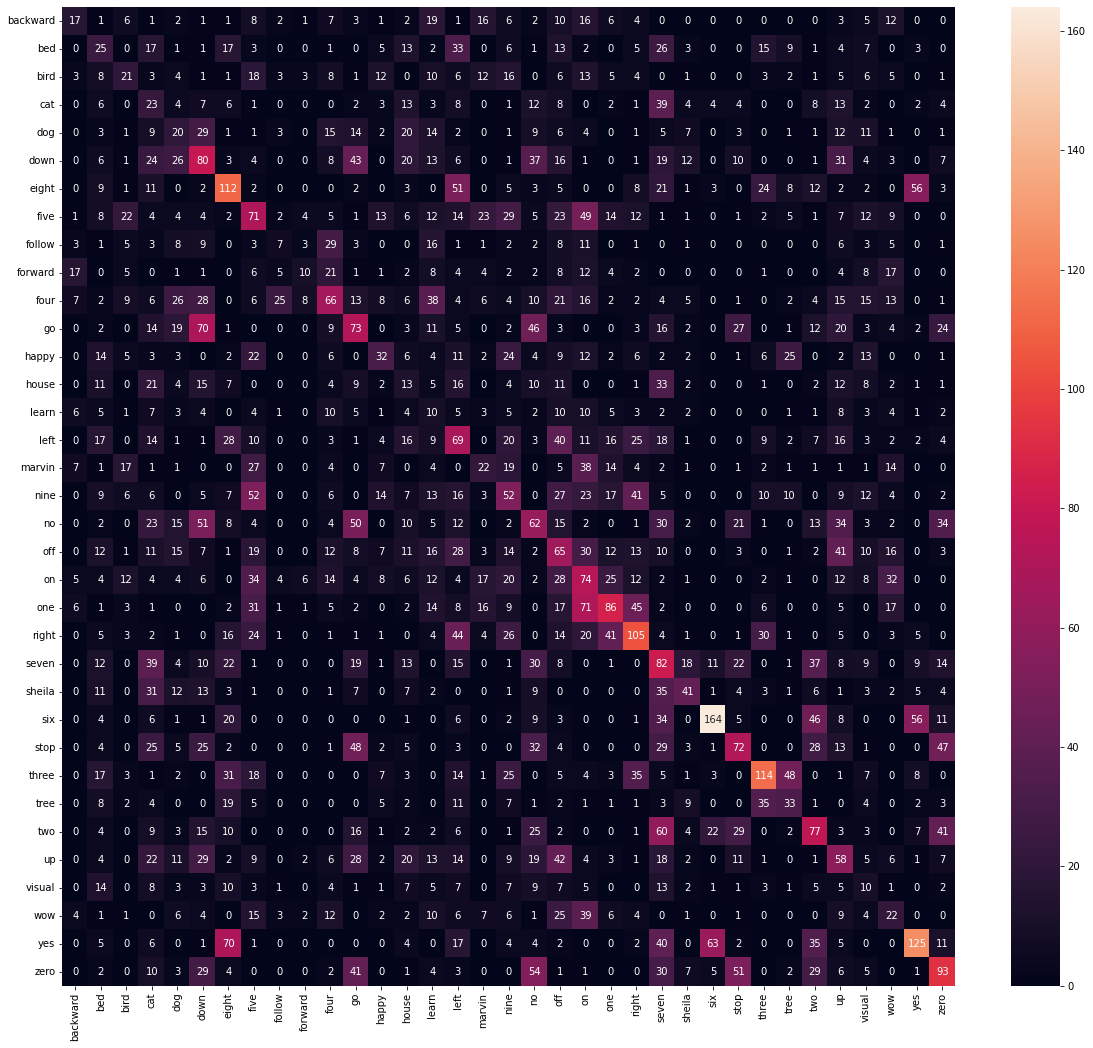

In [ ]:
LSTM_model = model
plot_conf_matrix(LSTM_model)

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        out, _ = self.gru(x, h0)  
        out = out[:, -1, :]
         
        out = self.fc(out)
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(categories)
learning_rate = 4e-5



model = GRU(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

losses_evolution, train_acc_evolution, val_acc_evolution = train(model, train_loader, criterion, optimizer, test_loader, valid_loader, sequence_length=sequence_length, input_size=input_size)

Epoch [1/50], Step [100/147], Loss: 3.4722


RuntimeError: ignored

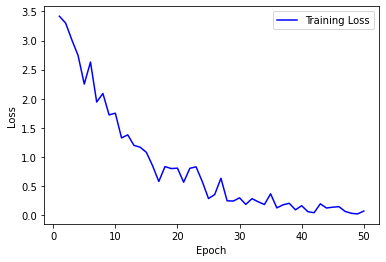

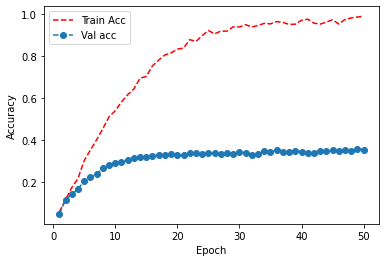

In [ ]:
plot_train_evo(losses_evolution, train_acc_evolution, val_acc_evolution)

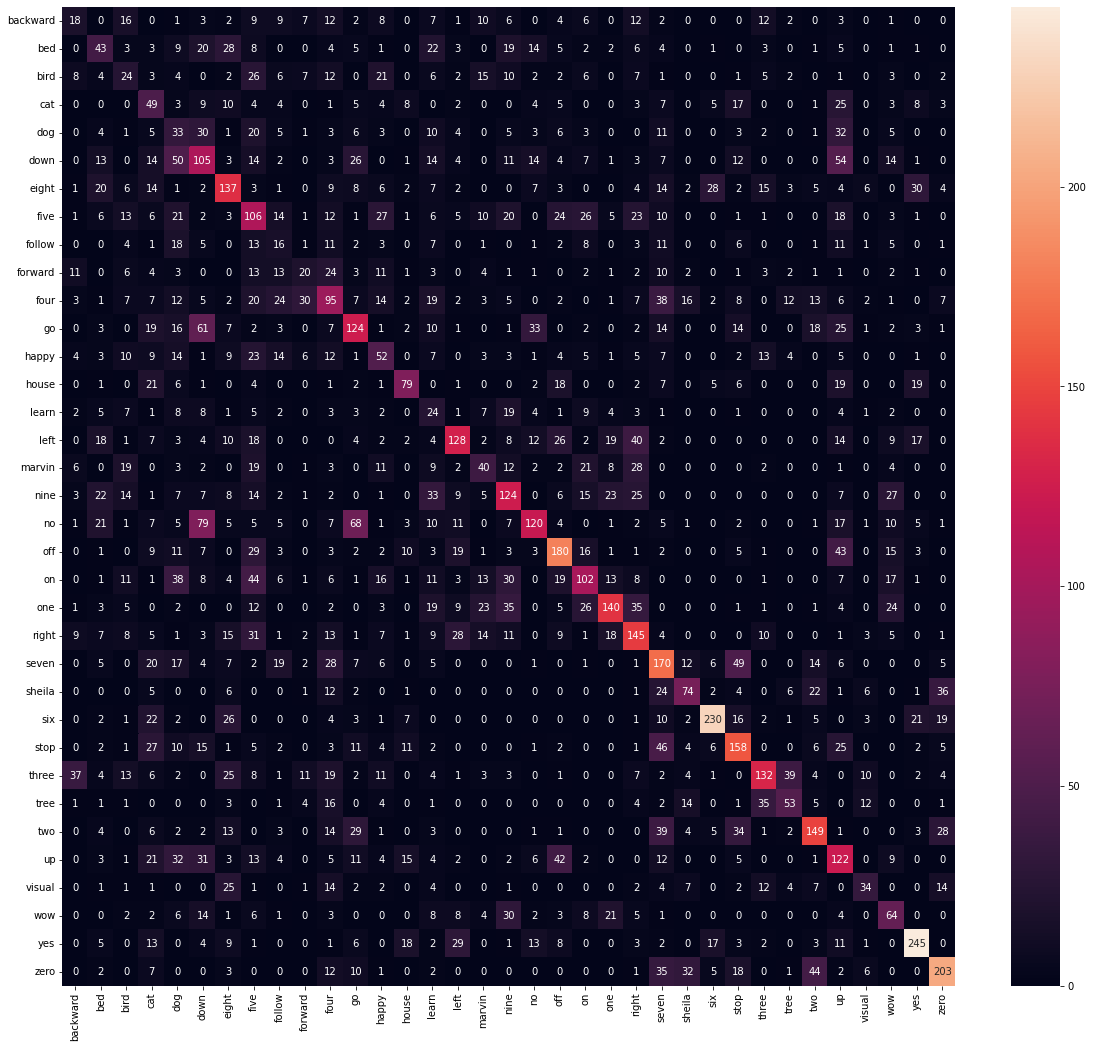

In [ ]:
GRU_model = model
plot_conf_matrix(GRU_model)

In [ ]:
torch.save(RNN_model, "/content/rnn35.pt")
torch.save(LSTM_model, "/content/lstm35.pt")
torch.save(GRU_model, "/content/gru35.pt")
